In [1]:
import os
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from process import get_data_osmFish, process_data
from train import train
warnings.filterwarnings("ignore")

In [2]:
visium_dataset = ['暂时不分']
dataset = visium_dataset
num_classes_list = [11]
start_k_neighbor_num = [8]
rad_distance_num = [500 for _ in range(len(dataset))]
alpha_lists = [[5.0] for _ in range(len(dataset))]
beta_lists = [[1.0] for _ in range(len(dataset))]
mid_k_neighbor_lists = [[8] for i in range(len(dataset))]
mid_feature_dims = []

In [3]:
adata_list_post = []
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
data_name = 'osmFish'
method = 'GraphSTAR'
hidden_dim = 30   # 聚类的维度
lr = 0.001
reg = 1e-5   
epochs = 1000
mode ='KNN'
save_adata_root = '../res/{}/{}/data'.format(method, data_name)
# 细胞识别还是组织域识别
is_cell_identify = False
metric_list = {"ARI": [], "AMI": [], "NMI": []}
print("当前训练的数据集: {}".format(data_name))
for index, section_id in enumerate(dataset):
    print("切片:", section_id, " 聚类数量:", num_classes_list[index])
    adata = get_data_osmFish()
    adata = process_data(adata, section_id)
    if is_cell_identify:
        adata.obs['Ground Truth'] = adata.obs['ClusterName']
    else: adata.obs['Ground Truth'] = adata.obs['Region']
    adata = train(adata, 
                  data_name=data_name, 
                  num_class=num_classes_list[index], 
                  mode=mode,
                  start_k_neighbor=start_k_neighbor_num[index], 
                  rad_distance=rad_distance_num[index], 
                  hidden_dim=hidden_dim,
                  mid_k_neighbor_list=mid_k_neighbor_lists[index],
                  alpha_list=alpha_lists[index],
                  beta_list=beta_lists[index], 
                  mid_feature_dims=mid_feature_dims,
                  lr=lr,
                  reg=reg,
                  epochs=epochs,
                  file_name=section_id,
                  device=device)
    adata_list_post.append(adata)
    metric = adata.uns['metric']
    metric_list['ARI'].append(metric['ARI'])
    metric_list["AMI"].append(metric['AMI'])
    metric_list["NMI"].append(metric['NMI'])
    print('slice = %s last metric:, ARI = %.2f, AMI = %.2f, NMI = %.2f' % (section_id, metric["ARI"], metric["AMI"], metric["NMI"]))



当前训练的数据集: osmFish
切片: 暂时不分  聚类数量: 11
请在这里添加预处理步骤！
空间位置的平均邻居数: tensor(9.3034)
空间位置的平均邻居数: tensor(9.3034)
in_features = 33, mid_feature1 = NULL, cluster_features = 30
begin training


100%|██████████| 1000/1000 [00:18<00:00, 53.76it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
slice = 暂时不分 last metric:, ARI = 0.69, AMI = 0.73, NMI = 0.73


In [4]:
for index, section_id in enumerate(dataset):
    # 保存到文件
    # 如果save_adata_root路径不存在
    if not os.path.exists(save_adata_root):
        os.makedirs(save_adata_root)
    adata = adata_list_post[index]
    full_path_save_data = os.path.join(save_adata_root, 'slice_{} adata.h5ad'.format(section_id))
    adata.write_h5ad(full_path_save_data)

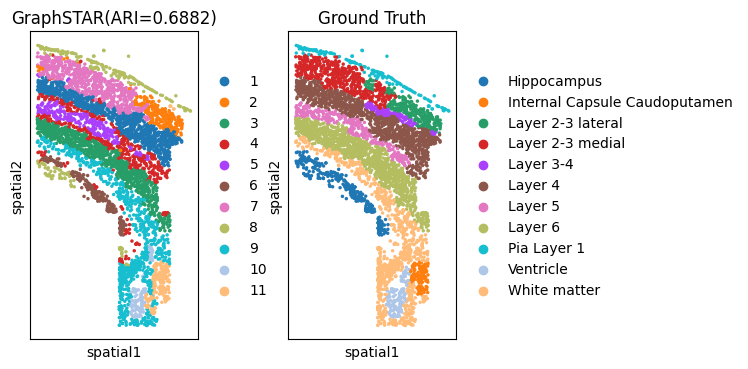

In [5]:
import scanpy as sc
for index, section_id in enumerate(dataset):
    adata = adata_list_post[index]
    plt.rcParams["figure.figsize"] = (2, 4)
    sc.pl.embedding(adata, basis='spatial', color=["predict", "Ground Truth"],
                title=['GraphSTAR(ARI={:.4f})'.format(metric_list['ARI'][index]), "Ground Truth"],
                save='slice_{}_spatial_plot.png'.format(section_id))

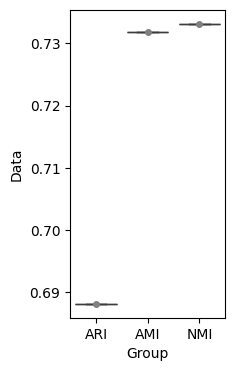

ARI mean = 0.688, ARI median = 0.688
AMI mean = 0.732, AMI median = 0.732
NMI mean = 0.733, NMI median = 0.733


In [6]:
# 绘制箱型图
df = pd.DataFrame({
    'Data': metric_list['ARI'] + metric_list['AMI'] + metric_list['NMI'],
    'Group': ['Data1'] * len(metric_list['ARI']) + ['Data2'] * len(metric_list['AMI']) + ['Data3'] * len(metric_list['NMI'])
})
sns.boxplot(x='Group', y='Data', data=df, hue='Group', legend=False)
sns.swarmplot(x='Group', y='Data', data=df, color='grey')
plt.xticks(ticks=[0, 1, 2], labels=['ARI', 'AMI', 'NMI'])

root = '../res/{}/{}/loss/'.format(method, data_name)
if not os.path.exists(root):
    os.makedirs(root)
if len(dataset) == 4:
    plt.savefig(os.path.join(root, '{}箱型图.png'.format(dataset[0] + "到" + dataset[3])))
else:
    plt.savefig(os.path.join(root, '总体箱型图.png'))
plt.show()

print("ARI mean = {:.3f}, ARI median = {:.3f}".format(np.mean(metric_list["ARI"]), np.median(metric_list["ARI"])))
print("AMI mean = {:.3f}, AMI median = {:.3f}".format(np.mean(metric_list["AMI"]), np.median(metric_list["AMI"])))
print("NMI mean = {:.3f}, NMI median = {:.3f}".format(np.mean(metric_list["NMI"]), np.median(metric_list["NMI"])))
